# Preliminary work
## Understand data and some plotting of grid and time series data

Steps for installation and this notebook (notes for myself)

1. get data, create environment (terminal)
- clone git repository: git clone https://github.com/PyPSA/pypsa-eur.git
- install miniconda and create environment and activate it:  conda env create -f envs/environment.yaml, conda activate pypsa-eur
- check which envi: conda info --envs
- install a solver: conda install -c conda-forge ipopt coincbc for non-linear (clustering) and linear problems (optimization)
- show solvers: conda list cbc / conda list ipopt
- install pypsa: conda install -c conda-forge pypsa

2. configuration file (terminal)
- then for whole network of germany: 
    - snakemake -call purge
    - cp config.default.yaml config.yaml
    - nano config/config.yaml
- snakemake simplify_network -n
- snakemake --until add_electricity --cores 4

3. explore data and network (this notebook)
- load network
- plot it and adjust the plotting paras
- check country and timesslot
- features: what is available, what is useful for clustering?


In [1]:
# import
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
plt.style.use ("bmh")
%matplotlib inline
import pandas as pd
import numpy as np
import pypsa

In [2]:
# load network
n = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/elec_s.nc")

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units


Country of electric grid: {'DE'}
Time range: 2013-01-01 00:00:00 to 2013-12-31 23:00:00
Number of snapshots:  8760


/opt/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


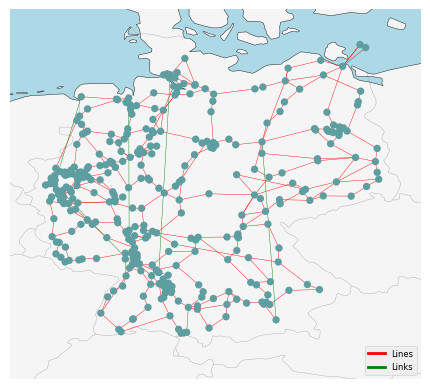

In [3]:
# country 
countries = n.buses["country"] 
print("Country of electric grid:" , set(countries))

# check time range
print("Time range:", n.snapshots.min(),  "to", n.snapshots.max())

# temporal resolution
# print(n.snapshots[:10])
print("Number of snapshots: ", len(n.snapshots))
num_snapshots =  len(n.snapshots)

# plot the electric grid
n.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths = 0.3, line_widths=0.3,  
       geomap = True, color_geomap=True, branch_components=["Line", "Link"], # when links and lines are there the overlapping turns out brownish
       line_colors="red", link_colors="green") # lines: red (passiive branch), links: green (controllable branch)

# Add a custom legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="red", lw=2, label="Lines"),
        plt.Line2D([0], [0], color="green", lw=2, label="Links")
    ],
    loc="lower right",  # Adjust as needed for the plot
    fontsize = 6
)
plt.show()


In [4]:
print(n.statistics())

                                  Optimal Capacity  Installed Capacity  \
Generator   Offshore Wind (AC)                 0.0        2.248066e+03   
            Offshore Wind (DC)                 0.0        5.538934e+03   
            Onshore Wind                       0.0        5.441367e+04   
            Open-Cycle Gas                     0.0        2.317065e+04   
            Run of River                       0.0        2.642453e+03   
            Solar                              0.0        5.366900e+04   
            biomass                            0.0        8.011736e+03   
            coal                               0.0        8.433879e+03   
            lignite                            0.0        2.123800e+04   
            nuclear                            0.0        4.066000e+03   
            oil                                0.0        9.499000e+02   
Line        AC                                 0.0        1.392578e+06   
StorageUnit Pumped Hydro Storage      

In [6]:
# print the components
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 339 entries
Component 'Carrier' has 18 entries
Component 'Line' has 486 entries
Component 'LineType' has 36 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 5 entries
Component 'Load' has 254 entries
Component 'Generator' has 2818 entries
Component 'StorageUnit' has 23 entries
Component 'Shape' has 341 entries


In [10]:
# Filter for coloums "solar"
solar_columns = [col for col in n.generators_t.p_max_pu.columns if 'solar' in col]

# Nur Solar-Werte extrahieren
solar_data = n.generators_t.p_max_pu[solar_columns]

# Ausgabe
print(solar_data.sum())


Generator
3371 solar     963.675767
3372 solar     979.177112
3373 solar    1001.740761
3374 solar     986.249607
3375 solar     999.284835
                 ...     
8828 solar     930.699187
8834 solar     927.421228
8847 solar     969.101152
8848 solar     922.693000
8863 solar     916.013330
Length: 322, dtype: float64


### available attributes

In [11]:
# display some information (availbale features of some components)
print("\nAvailable Attributes for Buses:")
print(n.buses.columns)

print("\nAvailable Attributes for Lines:")
print(n.lines.columns)

print("\nAvailable Attributes for Generators:")
print(n.generators.columns)

print("\nAvailable Attributes for Loads:")
print(n.loads.columns)



Available Attributes for Buses:
Index(['v_nom', 'type', 'x', 'y', 'carrier', 'unit', 'v_mag_pu_set',
       'v_mag_pu_min', 'v_mag_pu_max', 'control', 'generator', 'sub_network',
       'country'],
      dtype='object')

Available Attributes for Lines:
Index(['bus0', 'bus1', 'type', 'x', 'r', 'g', 'b', 's_nom', 's_nom_mod',
       's_nom_extendable', 's_nom_min', 's_nom_max', 's_max_pu',
       'capital_cost', 'active', 'build_year', 'lifetime', 'length', 'carrier',
       'terrain_factor', 'num_parallel', 'v_ang_min', 'v_ang_max',
       'sub_network', 'x_pu', 'r_pu', 'g_pu', 'b_pu', 'x_pu_eff', 'r_pu_eff',
       's_nom_opt', 'i_nom', 'v_nom'],
      dtype='object')

Available Attributes for Generators:
Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'e_sum_min',
       'e_sum_max', 'q_set', 'sign', 'carrier', 'marginal_cost',
       'marginal_cost_quadratic', 'active', 'build_year', 'lifeti

### display some features /  data

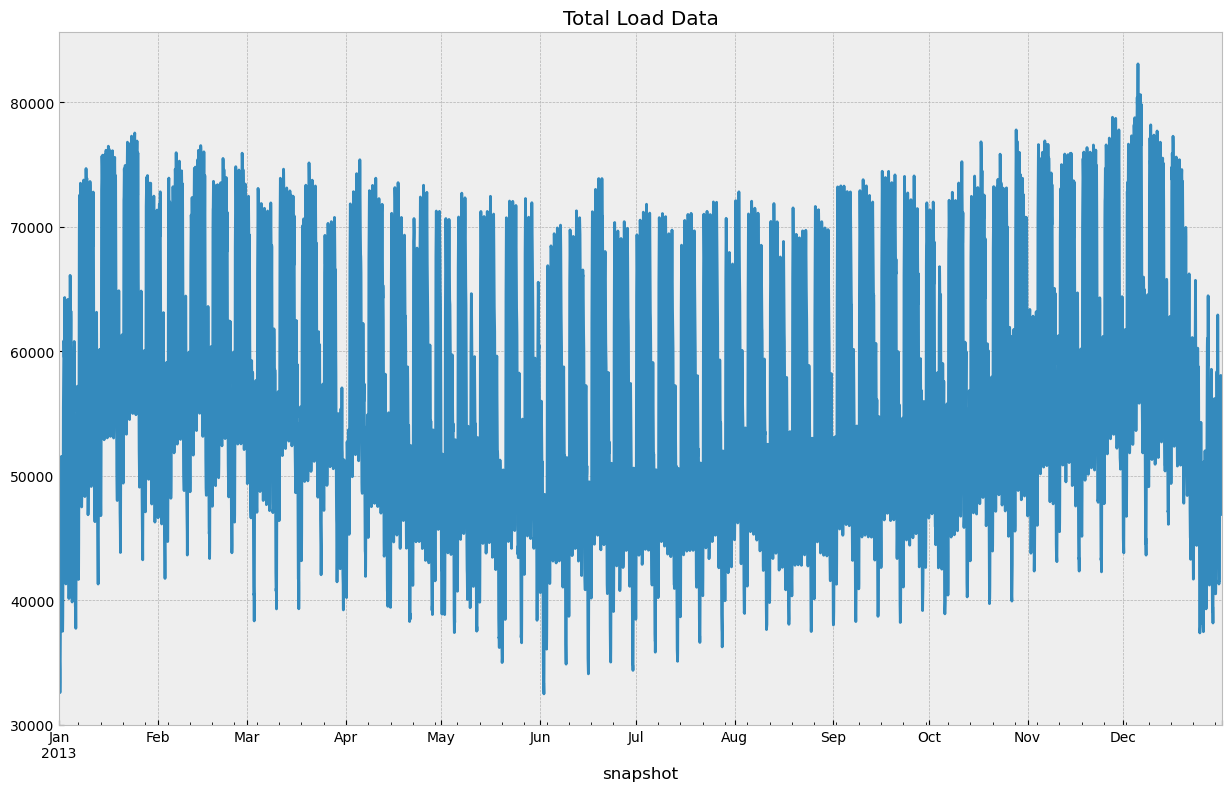

Sum of all p_set over all buses and all snapshots: 509158931.24410003 MW
Average of all p_set over all buses divided by number of snapshots: 58123.16566713471 MW


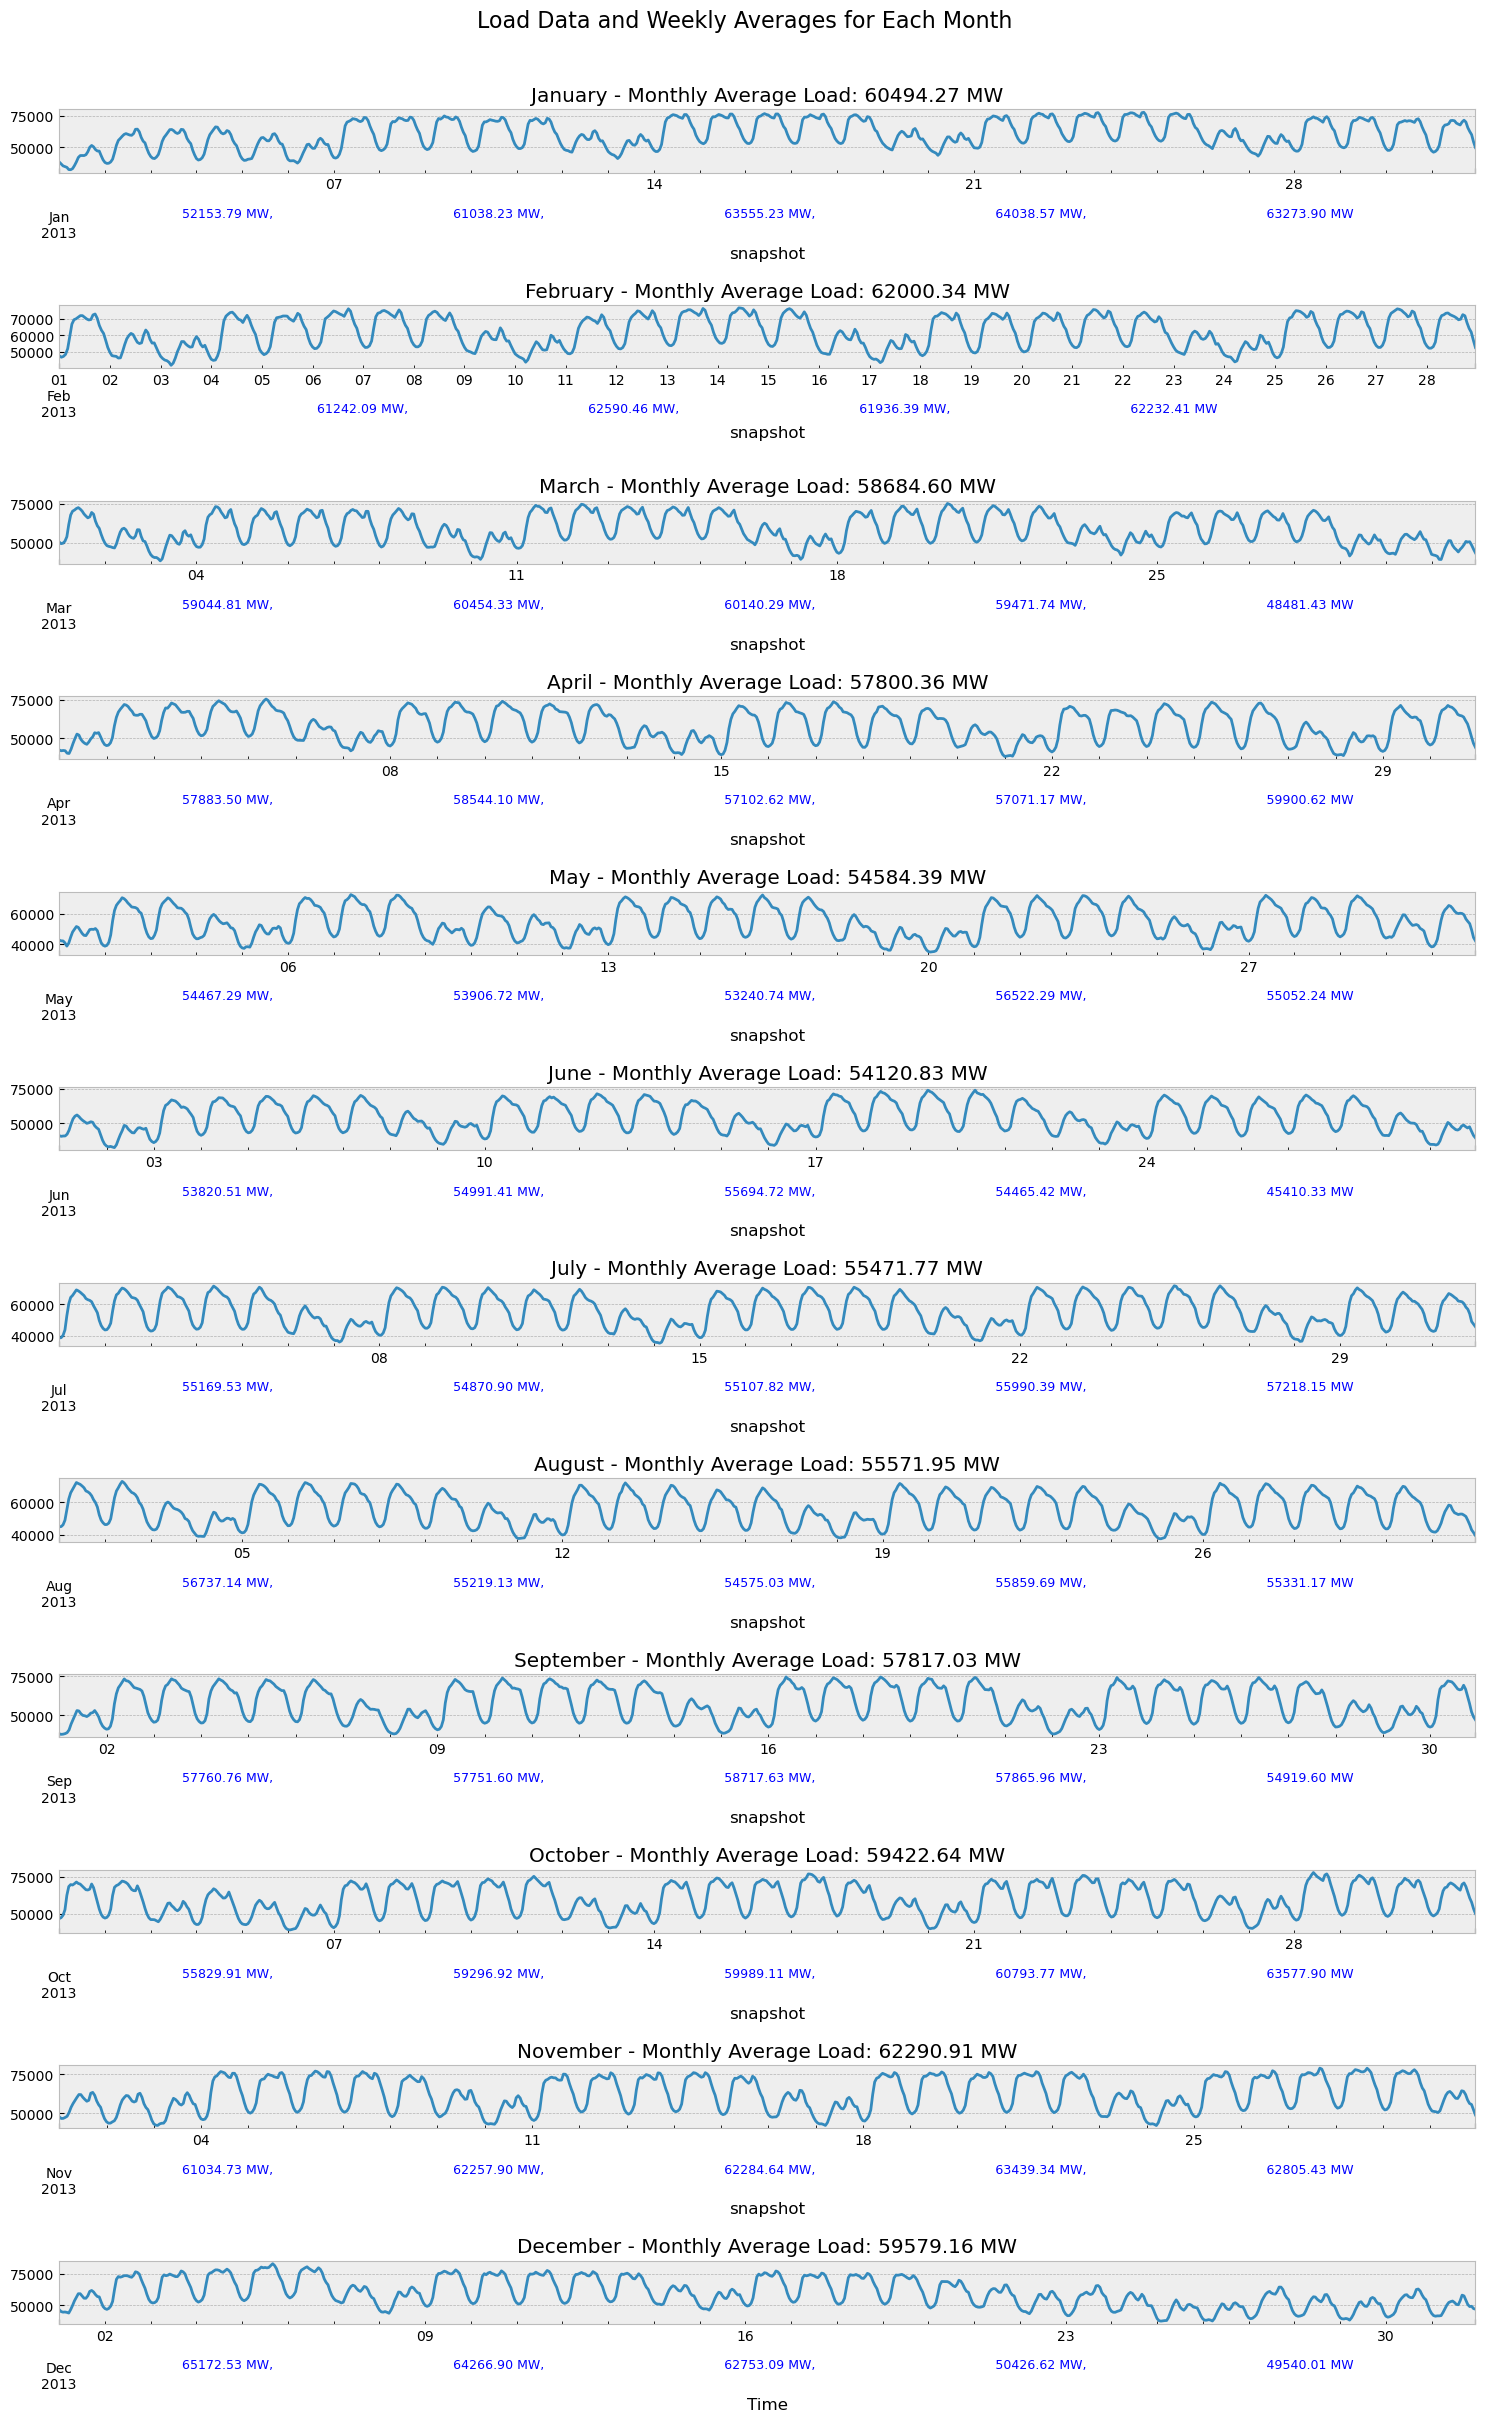

In [15]:
# LOADS
loads_t = n.loads_t # p = p_set here, q & q_set no data 
l_p_set = loads_t.p_set # active power consumption (positive if the load is consuming power
l_p = loads_t.p # active power at bus (positive if net load) (is the same as p_set)

# Plot the load data (sum of all nodes for each snapshot)
l_p_set.sum(axis=1).plot(title = "Total Load Data",figsize=(15, 9) )
plt.show()

# sum up or average the load per day (later by month / week etc.?)
print("Sum of all p_set over all buses and all snapshots:", l_p_set.sum(axis=1).sum(axis=0) , "MW")
print("Average of all p_set over all buses divided by number of snapshots:", l_p_set.sum(axis=1).sum(axis=0)/num_snapshots, "MW") # here its now hourwise and for 1 day

# Create a figure with 12 subplots (one for each month) arranged vertically
fig, axs = plt.subplots(12, 1, figsize=(15, 24))

# Iterate over each month from 1 to 12
for month in range(1, 13):
    # Select the data for the specific month
    month_data = n.loads_t.p_set[n.loads_t.p_set.index.month == month]
    
    # Calculate the total load by summing across all buses for each snapshot (daily totals)
    monthly_total = month_data.sum(axis=1)
    
    # Plot the daily total load data for the month
    ax = monthly_total.plot(ax=axs[month - 1], label="Daily Load")  # month - 1 because index starts at 0
    
    # Calculate weekly averages manually by iterating over days in chunks of 7
    weekly_averages = []
    num_days = len(monthly_total)
    steps = 7 * 24
    for i in range(0, num_days, steps):
        # Select a week of data (up to 7 days, depending on month end)
        weekly_data = monthly_total.iloc[i:i + steps]
        # Calculate the average load for the week
        weekly_avg = weekly_data.mean()
        weekly_averages.append(weekly_avg)

    # Display weekly averages below each plot as text

    weekly_avg_text = ",                                             ".join([f"{avg:.2f} MW" for avg in weekly_averages])
    ax.text(0.5, -0.7, f"{weekly_avg_text}", 
            transform=ax.transAxes, ha='center', fontsize=9, color='blue')

    monthly_avg_text = monthly_total.mean()
    # Set the title and labels for each subplot
    month_name = pd.to_datetime(month, format='%m').strftime('%B')
    ax.set_title(f"{month_name} - Monthly Average Load: {monthly_avg_text:.2f} MW")

# Set common labels and layout adjustments
plt.xlabel("Time")
plt.suptitle("Load Data and Weekly Averages for Each Month", y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


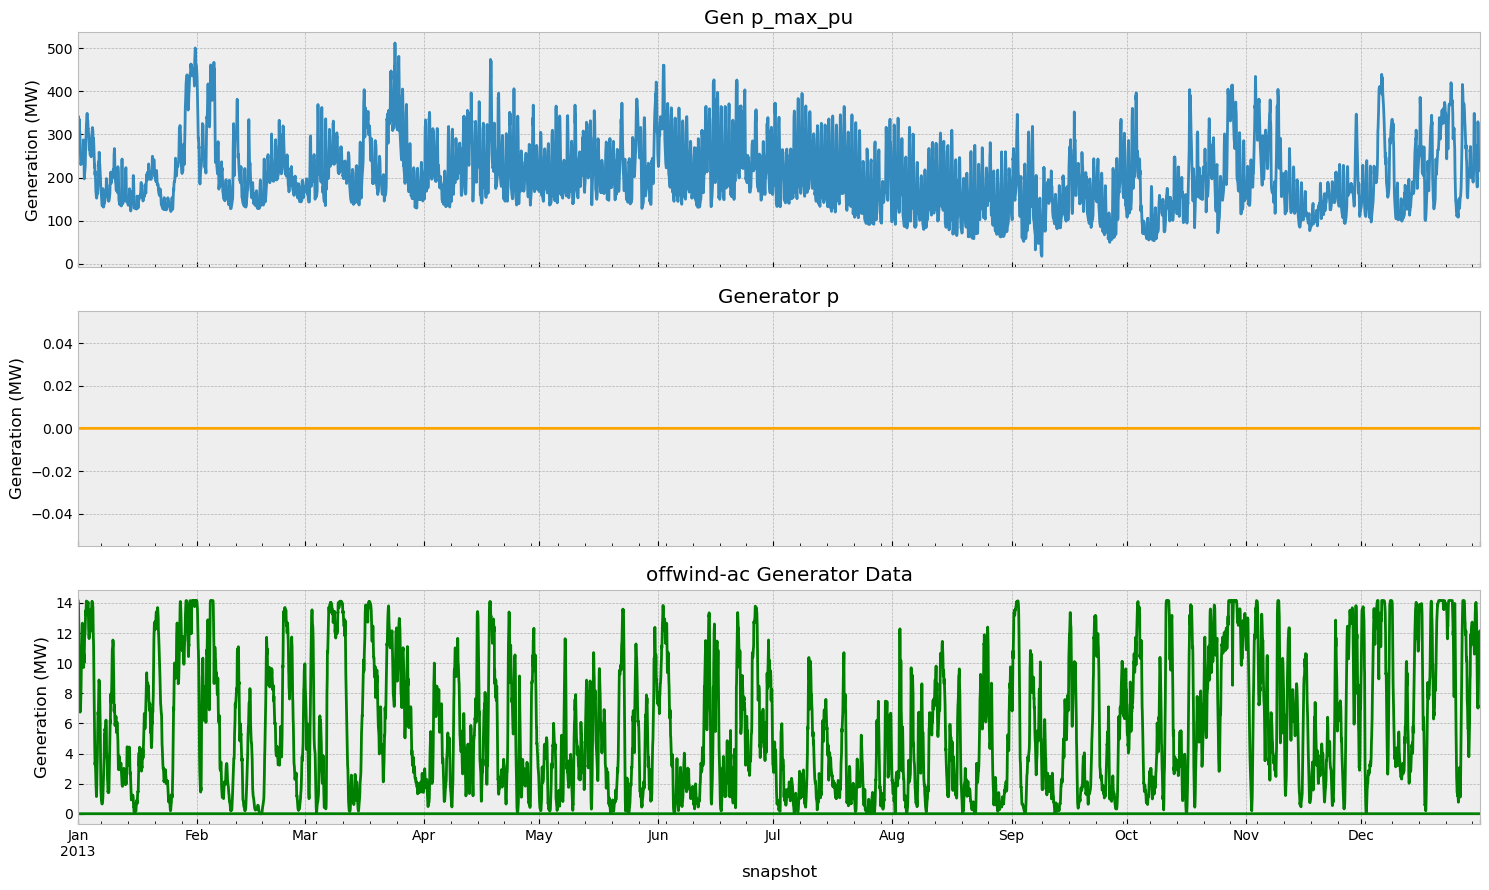

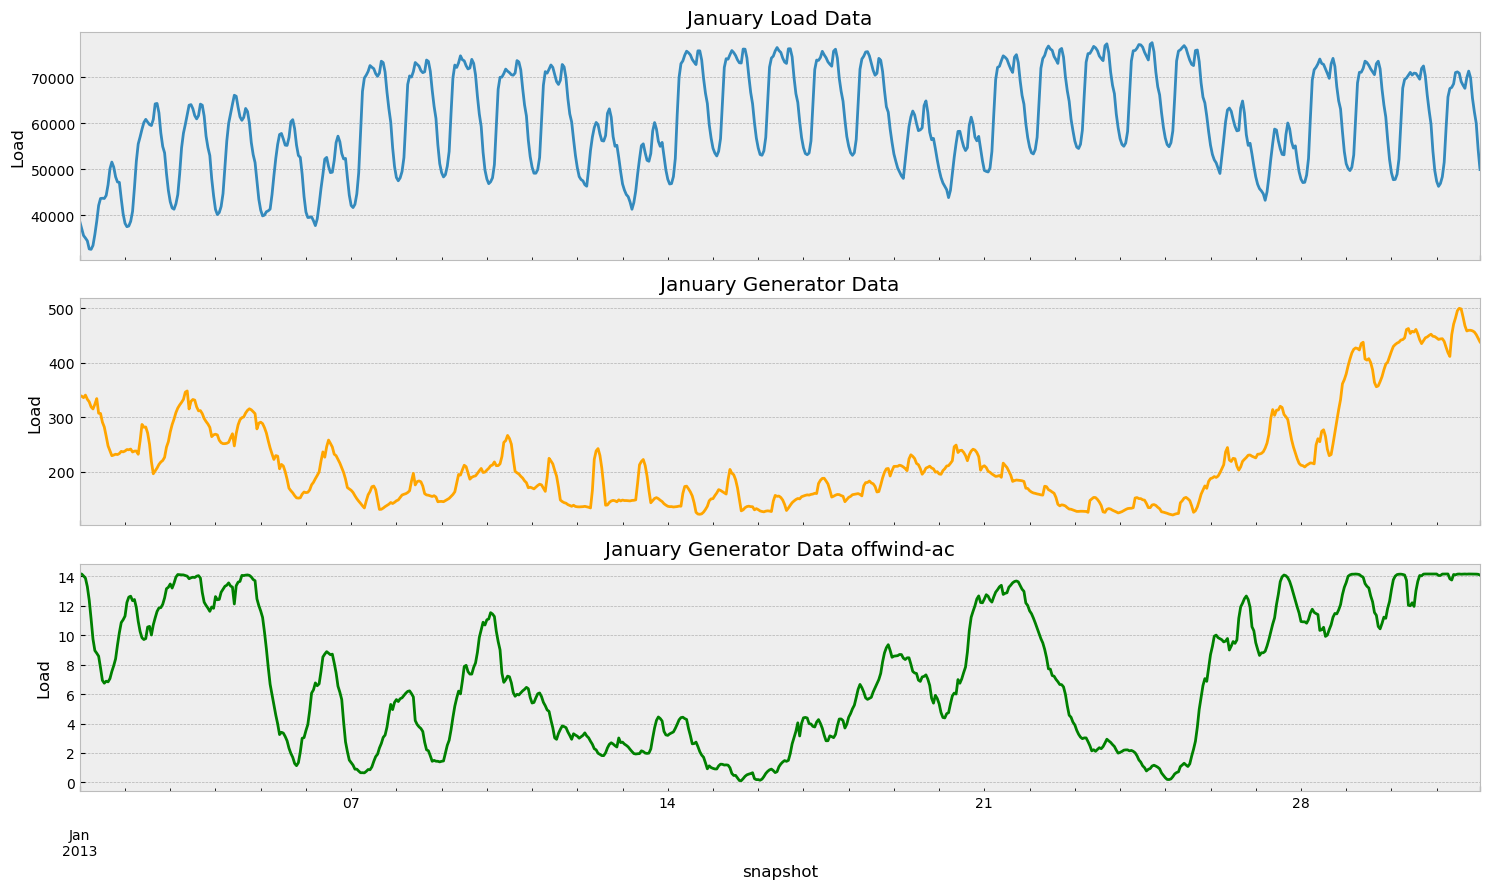

Sum of all p_set over all buses and all snapshots: 0.0 MW
Average of all p_set over all buses divided by number of snapshots: 0.0 MW


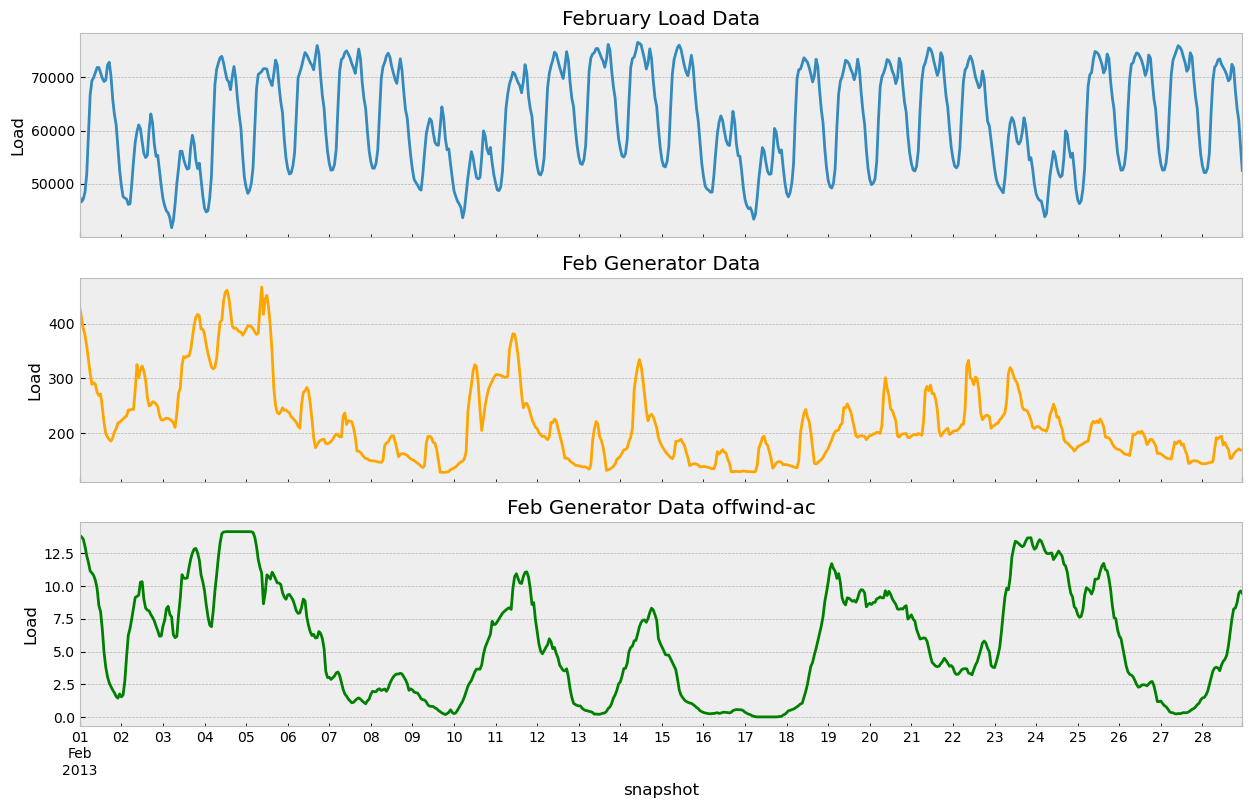

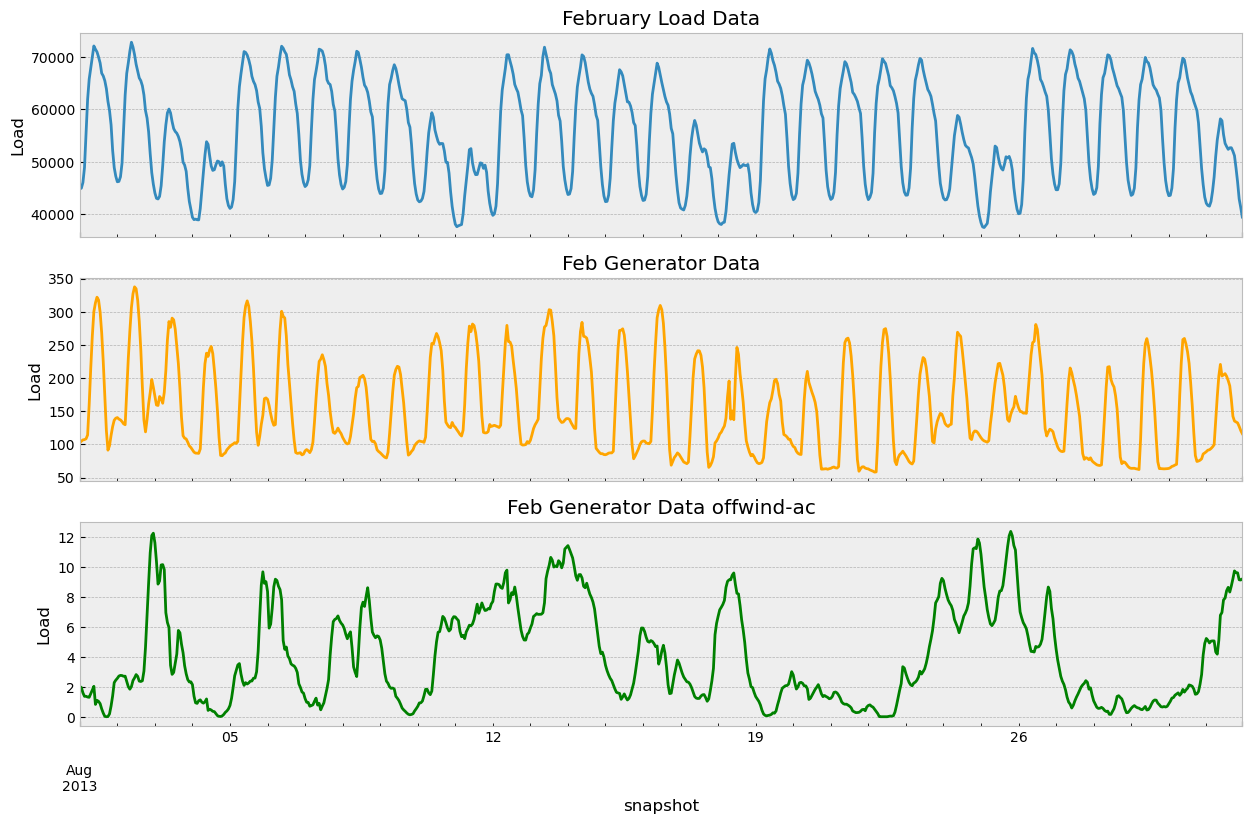

In [13]:
# GENERATOR

# p_max_pu , p, q is available right now

# Set up the figure and axes for 3 subplots vertically
fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
gen_t = n.generators_t
gen_t_pmax = gen_t.p_max_pu
gen_t_p = gen_t.p
gen_t_q = gen_t.q
# Plot the load data (sum of all nodes)

gen_t_pmax.sum(axis=1).plot(ax=axs[0])
axs[0].set_title("Gen p_max_pu")
axs[0].set_ylabel("Generation (MW)") 

# Plot the generator data (sum of all nodes and all types of genration) 
gen_t_p.sum(axis=1).plot(ax=axs[1], color="orange")
axs[1].set_title("Generator p")
axs[1].set_ylabel("Generation (MW)")

# Plot the generator data (sum of all nodes and all types of genration) 
gen_t_q.sum(axis=1).plot(ax=axs[2], color="green")
axs[2].set_title("Generator q")
axs[2].set_ylabel("Generation (MW)")


# Plot the generator data for one energy source e.g. offwind-ac
offwind_ac_generators = n.generators.index[n.generators.carrier == "offwind-ac"]
offwind_ac_p_max_pu = n.generators_t.p_max_pu[offwind_ac_generators]
offwind_ac_p_max_pu.sum(axis=1).plot(ax=axs[2], label="Total Offwind-AC", color="green", linewidth=2)
axs[2].set_title("offwind-ac Generator Data")
axs[2].set_ylabel("Generation (MW)")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# show one month for more detailed view
fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
january_data = n.loads_t.p_set[n.loads_t.p_set.index.month == 1]
ax = january_data.sum(axis=1).plot(ax=axs[0])
ax.set_title("January Load Data")
ax.set_ylabel("Load")  

january_data_gen = n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == 1]
ax = january_data_gen.sum(axis=1).plot(ax=axs[1], color="orange")
ax.set_title("January Generator Data")
ax.set_ylabel("Load")  

january_data_gen_offwind = offwind_ac_p_max_pu[offwind_ac_p_max_pu.index.month == 1]
ax = january_data_gen_offwind.sum(axis=1).plot(ax=axs[2], color="green")
ax.set_title("January Generator Data offwind-ac")
ax.set_ylabel("Load")  

plt.tight_layout()
plt.show()

# show one month for more detailed view
fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
january_data = n.loads_t.p_set[n.loads_t.p_set.index.month == 2]
ax = january_data.sum(axis=1).plot(ax=axs[0])
ax.set_title("February Load Data")
ax.set_ylabel("Load")  

january_data_gen = n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == 2]
ax = january_data_gen.sum(axis=1).plot(ax=axs[1], color="orange")
ax.set_title("Feb Generator Data")
ax.set_ylabel("Load")  

january_data_gen_offwind = offwind_ac_p_max_pu[offwind_ac_p_max_pu.index.month == 2]
ax = january_data_gen_offwind.sum(axis=1).plot(ax=axs[2], color="green")
ax.set_title("Feb Generator Data offwind-ac")
ax.set_ylabel("Load")  

# show one month for more detailed view
fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
january_data = n.loads_t.p_set[n.loads_t.p_set.index.month == 8]
ax = january_data.sum(axis=1).plot(ax=axs[0])
ax.set_title("February Load Data")
ax.set_ylabel("Load")  

january_data_gen = n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == 8]
ax = january_data_gen.sum(axis=1).plot(ax=axs[1], color="orange")
ax.set_title("Feb Generator Data")
ax.set_ylabel("Load")  

january_data_gen_offwind = offwind_ac_p_max_pu[offwind_ac_p_max_pu.index.month == 8]
ax = january_data_gen_offwind.sum(axis=1).plot(ax=axs[2], color="green")
ax.set_title("Feb Generator Data offwind-ac")
ax.set_ylabel("Load")  



# sum up or average the load per day (later by month / week etc.?)
print("Sum of all p_set over all buses and all snapshots:", gen_t_p.sum(axis=1).sum(axis=0) , "MW")
print("Average of all p_set over all buses divided by number of snapshots:", gen_t_p.sum(axis=1).sum(axis=0)/num_snapshots, "MW") # here its now hourwise and for 1 day

Text(0.5, 1.0, 'bus_t_marginal_price')

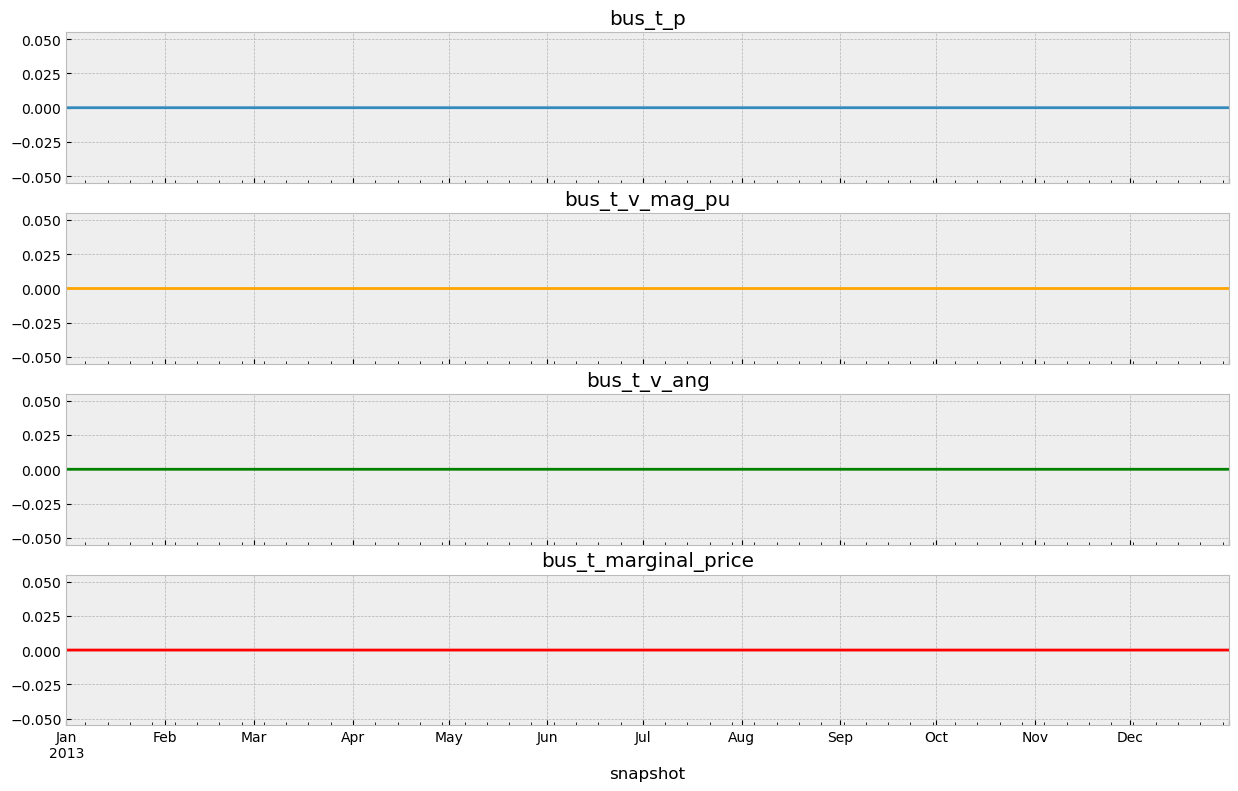

In [22]:
# BUSES
# marginal_price, p, v_mag_pu, v_ang

# Set up the figure and axes for 3 subplots vertically
fig, axs = plt.subplots(4, 1, figsize=(15, 9), sharex=True)
bus_t = n.buses_t
bus_t_p = bus_t.p
bus_t_v_mag_pu = bus_t.v_mag_pu
bus_t_v_ang = bus_t.v_ang
bus_t_marginal_price = bus_t.marginal_price
# Plot the load data (sum of all nodes)

bus_t_p.sum(axis=1).plot(ax=axs[0])
axs[0].set_title("bus_t_p")
#axs[0].set_ylabel("Generation (MW)") 

# Plot the generator data (sum of all nodes and all types of genration) 
bus_t_v_mag_pu.sum(axis=1).plot(ax=axs[1], color="orange")
axs[1].set_title("bus_t_v_mag_pu")
#axs[1].set_ylabel("Generation (MW)")

# Plot the generator data (sum of all nodes and all types of genration) 
bus_t_v_ang.sum(axis=1).plot(ax=axs[2], color="green")
axs[2].set_title("bus_t_v_ang")
#axs[2].set_ylabel("Generation (MW)")

# Plot the generator data (sum of all nodes and all types of genration) 
bus_t_marginal_price.sum(axis=1).plot(ax=axs[3], color="red")
axs[3].set_title("bus_t_marginal_price")
#axs[3].set_ylabel("Generation (MW)")

### Insvestigate data & distribution for normalization

Normalizaiton is necassary --> min max beacuse we dont have outliers and its not a normal distribution (in such a case z-transformation)
So scaling the values into [0,1]

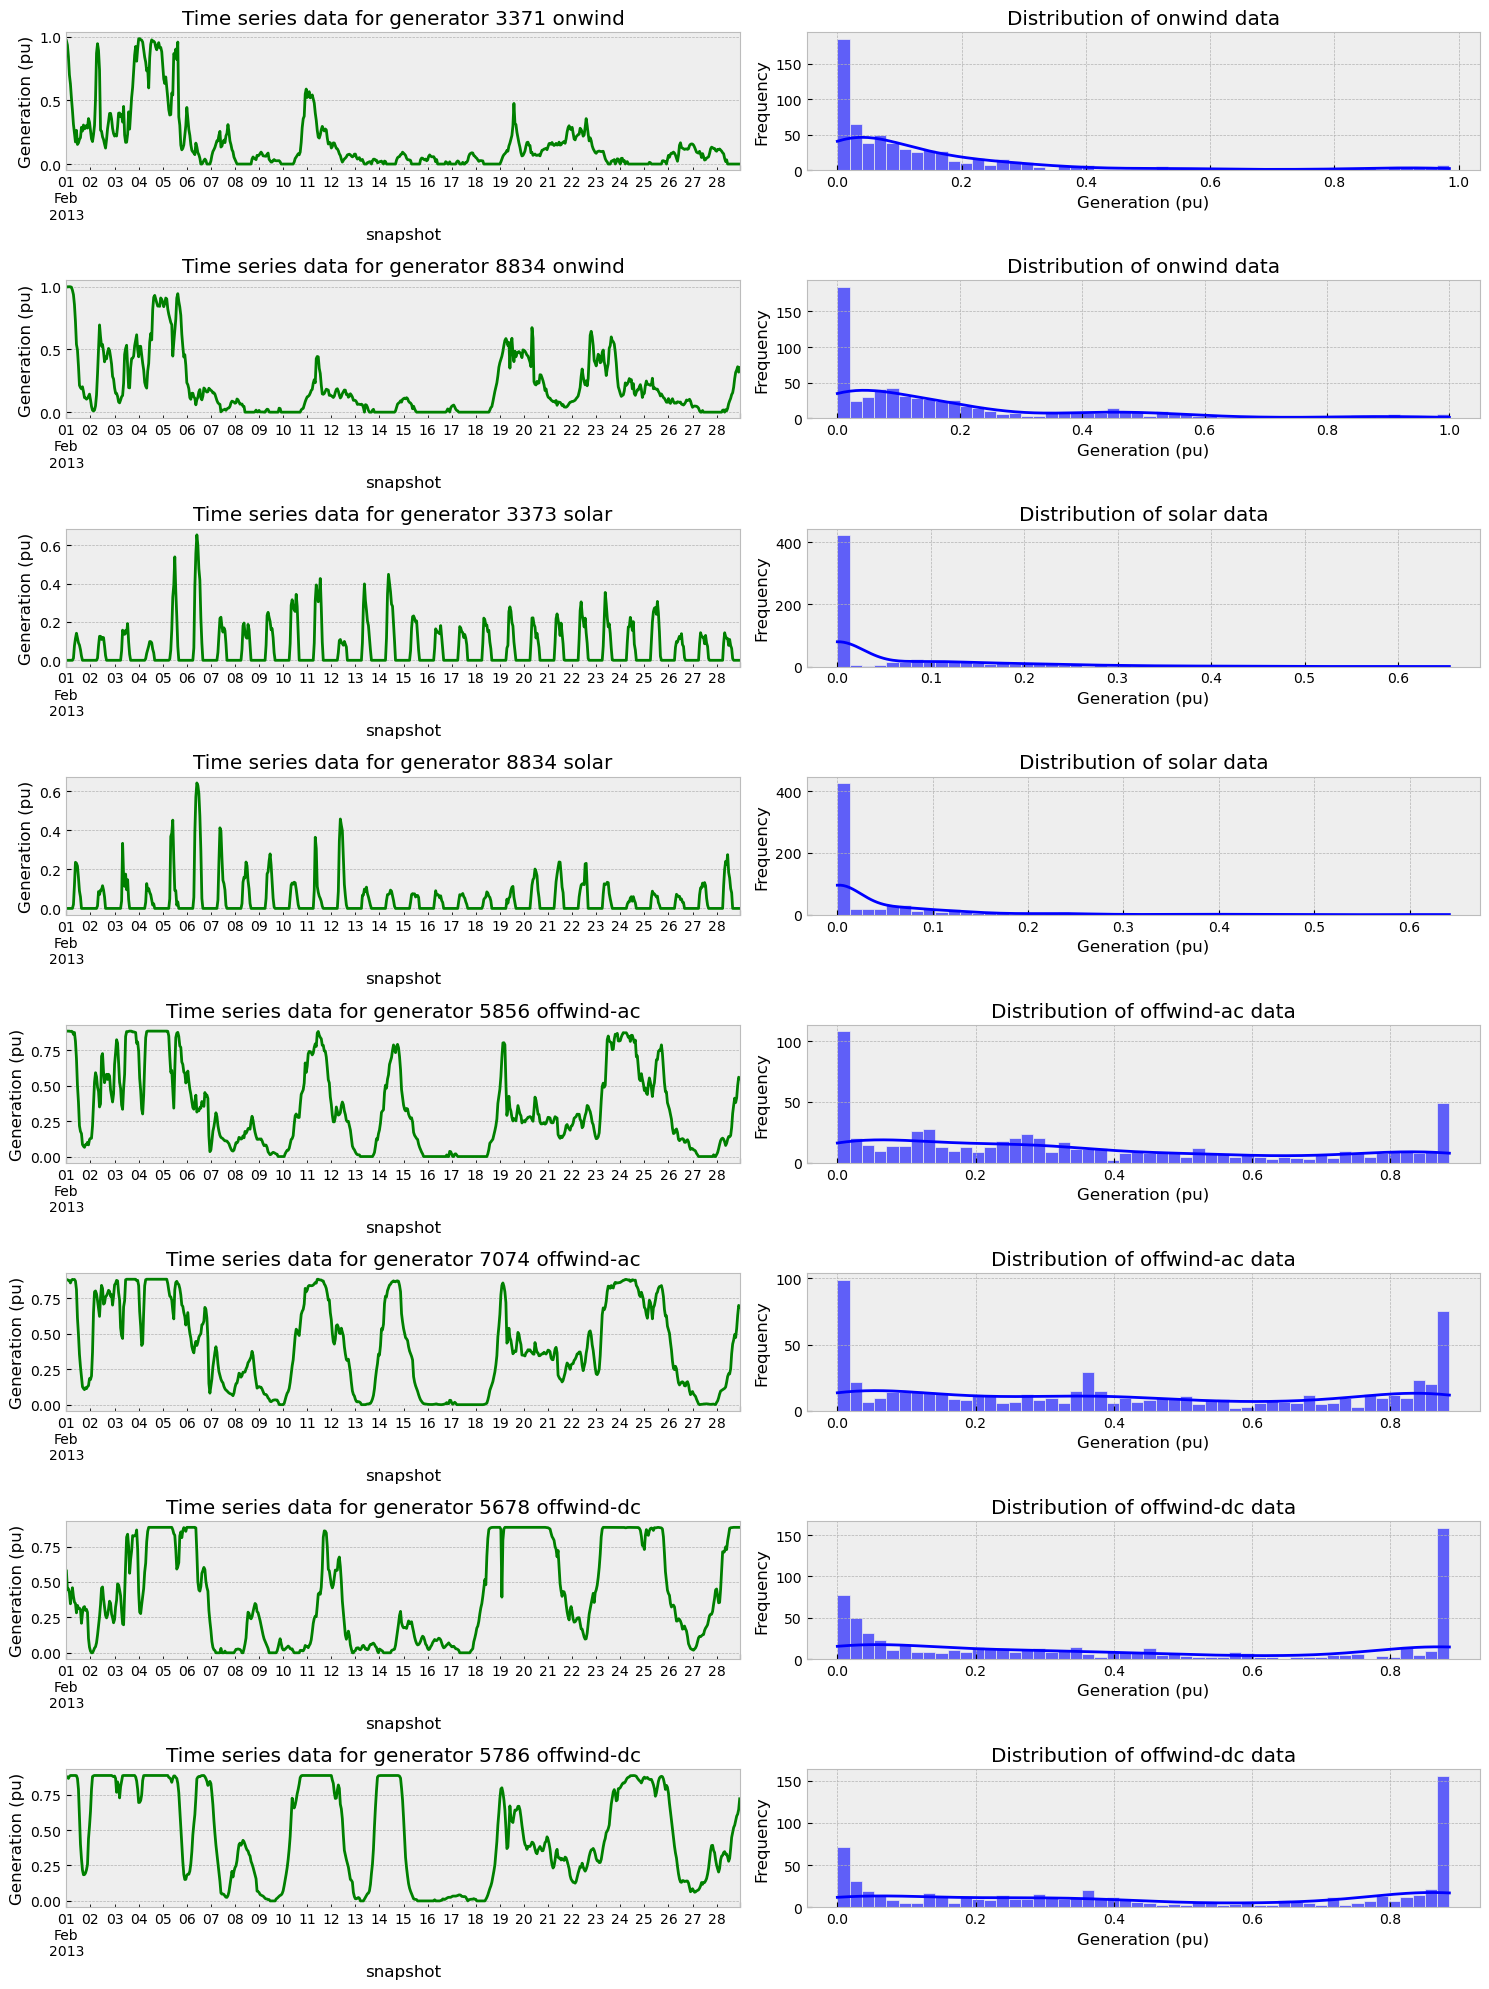

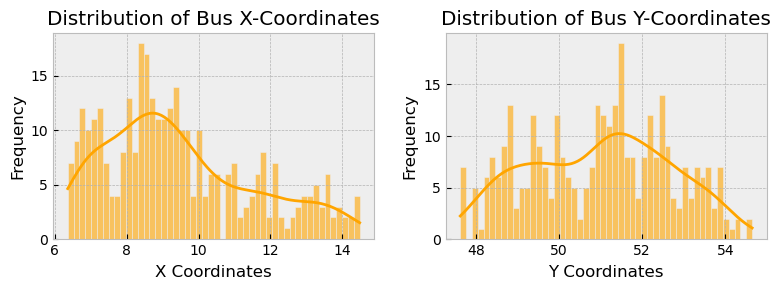

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_monthly_data(month, n, gen_name1, gen_name2, gen_name3, gen_name4, gen_name5, gen_name6, gen_name7, gen_name8):
# def plot_monthly_data(month, n, load_name1, load_name2, load_name3, load_name4, load_name5, load_name6, load_name7, load_name8):
    """ generate time series and histogram plots for a specific month and generator type
   
    Args:
    - month: month for which to generate the data (1 for January, 8 for August, etc.)
    - n: pypsa network containing the time series data
    - load_name1, load_name2, load_name3, load_name4: Load names to plot
    - gen_name1, gen_name2, gen_name3, gen_name4: Generator names to plot
    """
    
    fig, axs = plt.subplots(8, 2, figsize=(15, 20))
    
    # List of load and generator data to be plotted ! change if you want gen or load !
    """
    data_list = [
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name1], f"Time series data of load for {load_name1}", "Load (MW)"),
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name2], f"Time series data of load for {load_name2}", "Load (MW)"),
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name3], f"Time series data of load for {load_name3}", "Load (MW)"),
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name4], f"Time series data of load for {load_name4}", "Load (MW)"),
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name5], f"Time series data of load for {load_name5}", "Load (MW)"),
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name6], f"Time series data of load for {load_name6}", "Load (MW)"),
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name7], f"Time series data of load for {load_name7}", "Load (MW)"),
        (n.loads_t.p_set[n.loads_t.p_set.index.month == month][load_name8], f"Time series data of load for {load_name8}", "Load (MW)")
        ]
    """
    data_list = [
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name1], f"Time series data for generator {gen_name1}", "Generation (pu)"),
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name2], f"Time series data for generator {gen_name2}", "Generation (pu)"),
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name3], f"Time series data for generator {gen_name3}", "Generation (pu)"),
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name4], f"Time series data for generator {gen_name4}", "Generation (pu)"),
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name5], f"Time series data for generator {gen_name5}", "Generation (pu)"),
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name6], f"Time series data for generator {gen_name6}", "Generation (pu)"),
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name7], f"Time series data for generator {gen_name7}", "Generation (pu)"),
        (n.generators_t.p_max_pu[n.generators_t.p_max_pu.index.month == month][gen_name8], f"Time series data for generator {gen_name8}", "Generation (pu)")
        ]

    
    for i, (data, title, ylabel) in enumerate(data_list):
        ax = data.plot(ax=axs[i, 0], color="green")  # plot time series data
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        #ax.set_xlabel("Day")
        
        # plot histograms to see data distribution
        sns.histplot(data, bins=50, ax=axs[i, 1], kde=True, color="blue", alpha=0.6)
        axs[i, 1].set_title(f"Distribution of {title.split(' ')[-1]} data")
        axs[i, 1].set_xlabel(ylabel)
        axs[i, 1].set_ylabel("Frequency")
    
        
    plt.tight_layout()
    plt.show()
    return data

# Example usage:
b = plot_monthly_data(2, n, "3371 onwind", "8834 onwind", "3373 solar", "8834 solar", "5856 offwind-ac", "7074 offwind-ac", '5678 offwind-dc', '5786 offwind-dc') #kibidi
#b = plot_monthly_data(1, n, "3371", "3373", '8737', '8599', '3793', '3794', '3796', '3798') # for loads (there are all the same)
        
############# coordiantes #############
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(n.buses.x.values, bins=50, kde=True, ax=axs[0], color="orange", alpha=0.6)
axs[0].set_title("Distribution of Bus X-Coordinates")
axs[0].set_xlabel("X Coordinates")
axs[0].set_ylabel("Frequency")
axs[0].xaxis.labelpad = 5  # Move x-axis label closer to axis

sns.histplot(n.buses.y.values, bins=50, kde=True, ax=axs[1], color="orange", alpha=0.6)
axs[1].set_title("Distribution of Bus Y-Coordinates")
axs[1].set_xlabel("Y Coordinates")
axs[1].set_ylabel("Frequency")
axs[1].xaxis.labelpad = 5  # Move x-axis label closer to axis

plt.tight_layout()
plt.show()


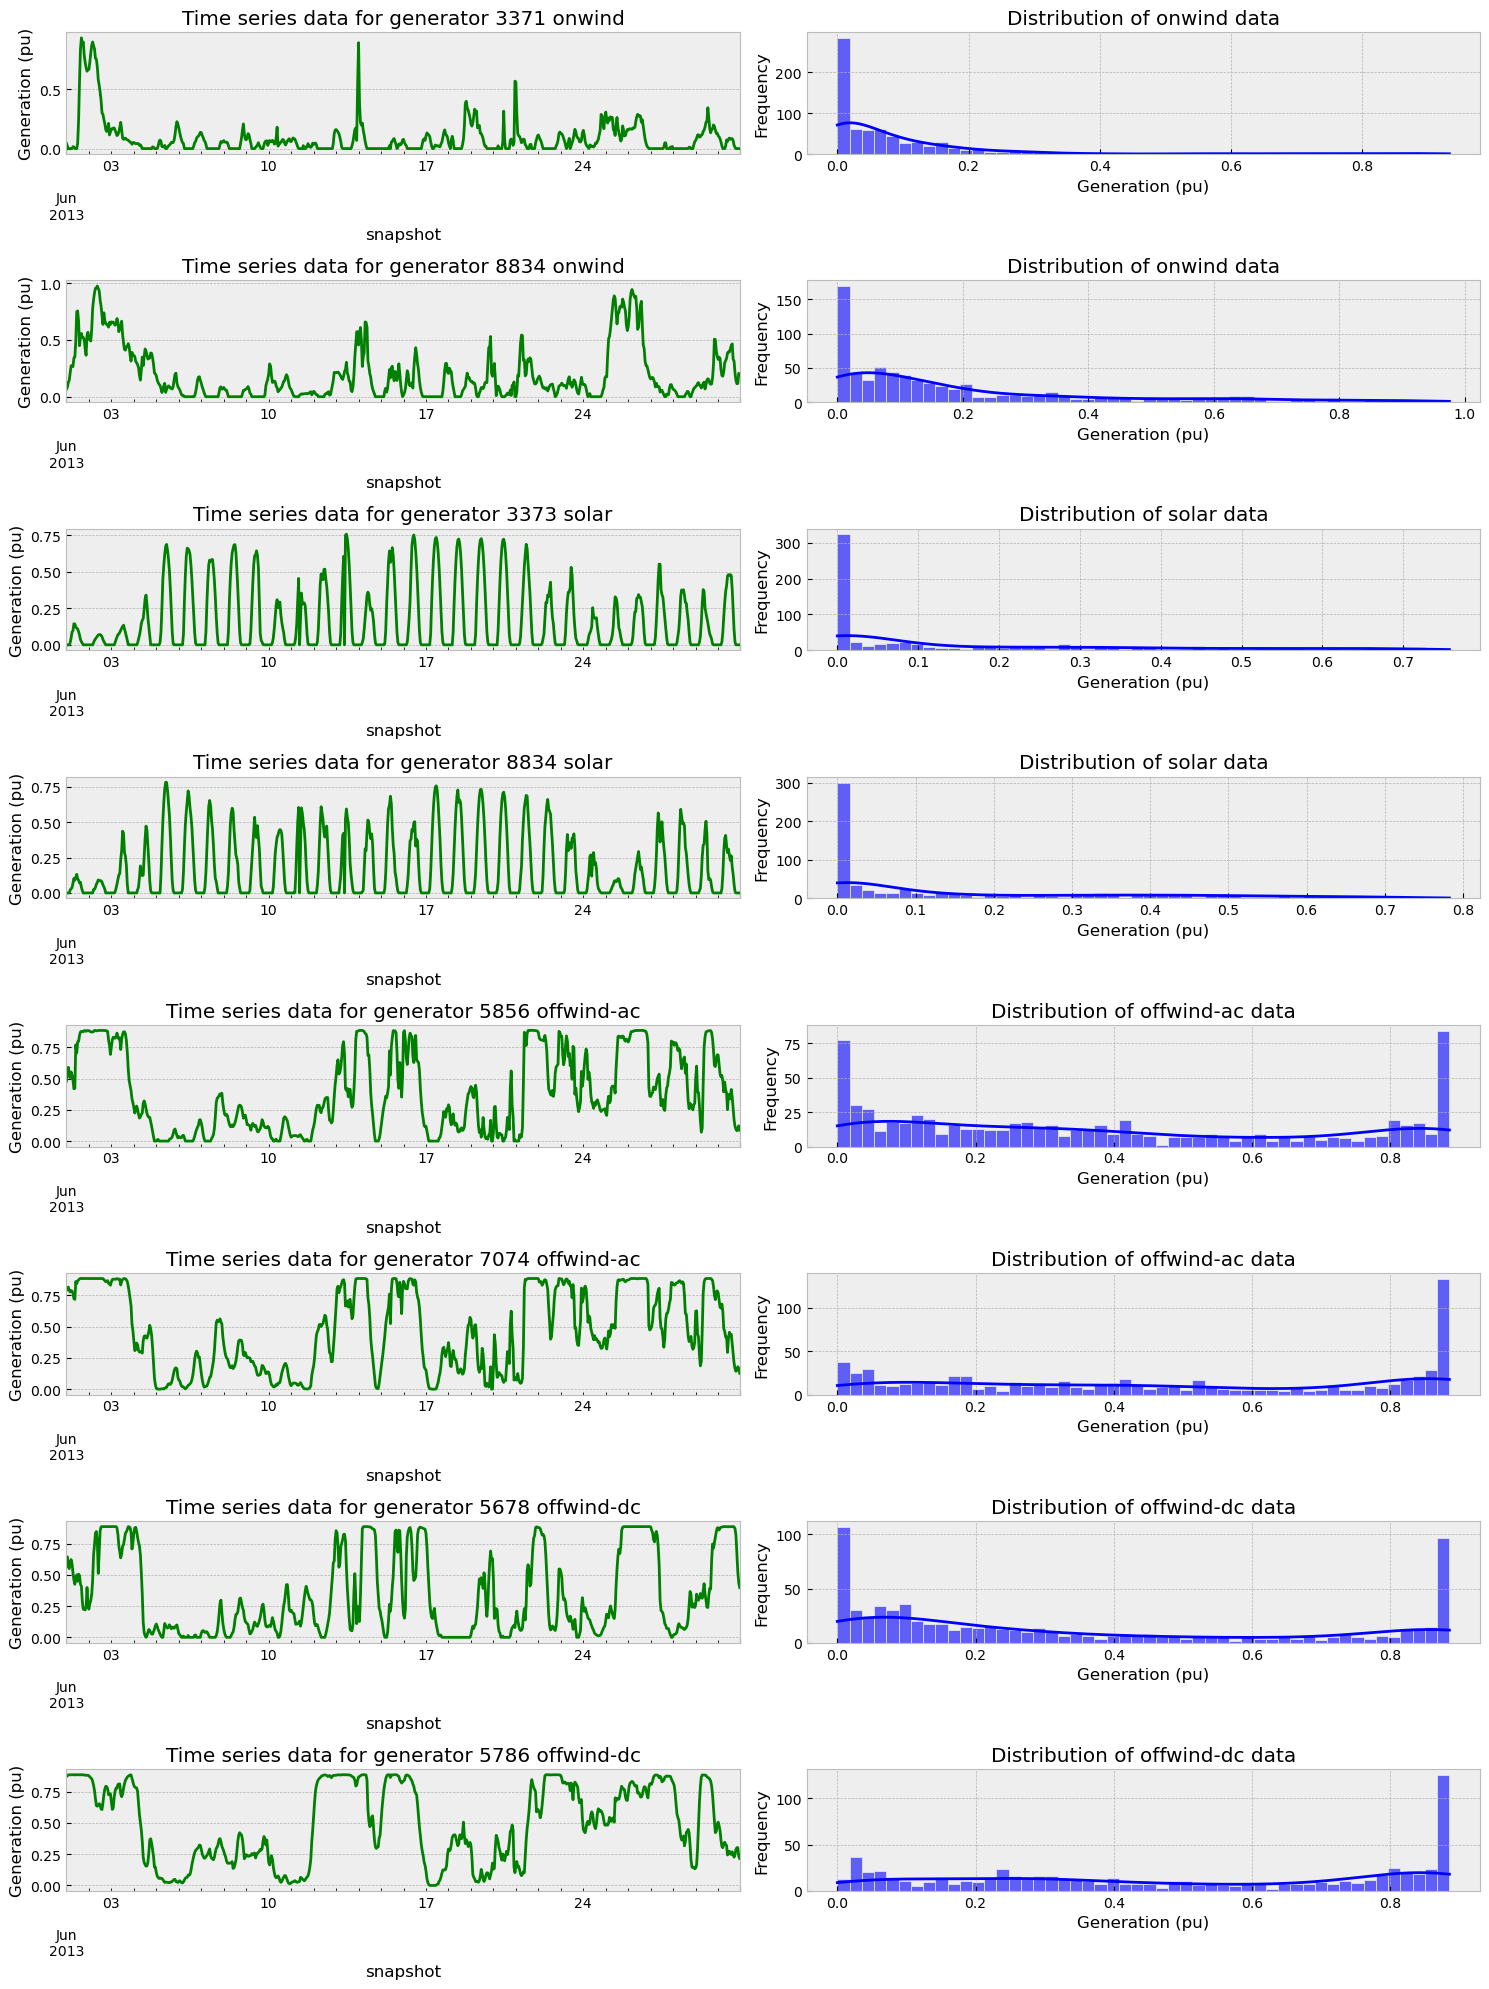

In [19]:
b = plot_monthly_data(6, n, "3371 onwind", "8834 onwind", "3373 solar", "8834 solar", "5856 offwind-ac", "7074 offwind-ac", '5678 offwind-dc', '5786 offwind-dc') #kibidi

In [28]:
# STORES: no data available
n.stores
#n.storage_units

Empty DataFrame
Columns: [bus, type, carrier, e_nom, e_nom_mod, e_nom_extendable, e_nom_min, e_nom_max, e_min_pu, e_max_pu, e_initial, e_initial_per_period, e_cyclic, e_cyclic_per_period, p_set, q_set, sign, marginal_cost, marginal_cost_quadratic, marginal_cost_storage, capital_cost, standing_loss, active, build_year, lifetime, e_nom_opt]
Index: []

[0 rows x 26 columns]

In [37]:
n.explore()

INFO:pypsa.plot:Components rendered on the map: Bus, Line, Link.
INFO:pypsa.plot:Components omitted as they are missing or not selected: Generator, Load, StorageUnit, Transformer.
